<a href="https://colab.research.google.com/github/hirajya/CCMACLRL_EXERCISES_COM222/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [796]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [797]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [798]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [799]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [800]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [801]:
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


In [802]:
df_validation.head(10)

,text,label
0,VinTee [USERNAME] [USERNAME] and [USERNAME] Ka...,1
1,binay's sidekicks were employees of makati cit...,1
2,This is expected as we use different methodol...,0
3,Ang tanga tanga talaga ni Nancy Binay eh. Tskkk.,1
4,Binay giving away bracelets after every selfie...,0
5,Sana alam ni mar roxas yung mga pinagsasabi niya,1
6,letse naman leni wala ka tlgang magawa?!,1
7,Bilong ?? [USERNAME] [USERNAME] Alam na ni Lit...,1
8,Binay still mum on performance at PiliPinas De...,1
9,are these dreamers that wont happen and they w...,0


In [803]:
df_test.head(10)

,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
5,Jeonghan said Let Leni Lead!! Lenihae ahahhdjfj,0
6,[USERNAME] [USERNAME]and[USERNAME] Hahahhahaha...,1
7,[USERNAME] Attendees of the CNNPHVPDebate are ...,0
8,Abscbn News Hoaxnews ng abias cbend baklas pos...,1
9,NEWS UPDATE: The camp of VP Leni Robredo says ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [804]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [805]:
df_train.isnull().sum()

,0
text,0
label,0


In [806]:
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [807]:
duplicate_rows_train = df_train[df_train.duplicated()]
print("Duplicate Rows in Train Dataset:")
print(duplicate_rows_train)

Duplicate Rows in Train Dataset:
Empty DataFrame
Columns: [text, label]
Index: []


5. Check how many rows belong to each class

In [808]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [809]:
print(f"df_train shape (before): {df_train.shape}")
df_train = df_train.drop_duplicates()
print(f"df_train shape (after): {df_train.shape}")



df_train shape (before): (21773, 2)
df_train shape (after): (21773, 2)


7. Remove rows with NaN values

In [810]:
print(f"df_train shape (before): {df_train.shape}")
df_train = df_train.dropna()
print(f"df_train shape (after): {df_train.shape}")


df_train shape (before): (21773, 2)
df_train shape (after): (21773, 2)


8. Convert all text to lowercase

In [811]:
df_train['text'] = df_train['text'].str.lower()
df_validation['text'] = df_validation['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()


9. Remove digits, URLS and special characters

In [812]:
def remove_digits_urls_special_chars(text):
  text = re.sub(r'\d+', '', text)  # Remove digits
  text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
  text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
  return text

df_train['text'] = df_train['text'].apply(remove_digits_urls_special_chars)
df_validation['text'] = df_validation['text'].apply(remove_digits_urls_special_chars)
df_test['text'] = df_test['text'].apply(remove_digits_urls_special_chars)


10. Remove stop words

In [813]:
tagalog_stop_words = set([
    'ang', 'ng', 'si', 'sa', 'mga', 'na', 'ay', 'at', 'ko', 'ikaw', 'kami', 'kayo',
    'nila', 'natin', 'ni', 'niya', 'nito', 'namin', 'sila', 'ito', 'iyon', 'doon',
    'dito', 'may', 'wala', 'ngayon', 'noon', 'din', 'rin', 'nang', 'ba', 'pa',
    'nga', 'kung', 'ano', 'bakit', 'paano', 'lahat', 'dahil', 'gusto', 'para',
    'pero', 'kasi', 'kanina', 'kahapon', 'wala', 'lamang', 'hanggang', 'mula', 'bago',
    'pag', 'nasa', 'kung', 'tulad', 'kapag', 'habang', 'dati', 'saan', 'pati',
    'ni', 'man', 'ngunit', 'subalit', 'o', 'dapat', 'naman'
])

stop_words = set(stopwords.words('english')) | tagalog_stop_words
# stop_words = tagalog_stop_words


def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df_train['text'] = df_train['text'].apply(remove_stopwords)
df_validation['text'] = df_validation['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)


11. Use Stemming or Lemmatization

In [814]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_text(text):
  return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatize_text(text):
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_train['text'] = df_train['text'].apply(stem_text)
df_validation['text'] = df_validation['text'].apply(stem_text)
df_test['text'] = df_test['text'].apply(stem_text)

# df_train['text'] = df_train['text'].apply(lemmatize_text)
# df_validation['text'] = df_validation['text'].apply(lemmatize_text)
# df_test['text'] = df_test['text'].apply(lemmatize_text)


## C. Training your model

12. Put all text training data in variable **X_train**

In [815]:
X_train = df_train['text']


13. Put all training data labels in variable **y_train**

In [816]:
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [817]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_train_transformed = vectorizer.fit_transform(X_train)


In [818]:
# vectorizer = CountVectorizer()
# X_train_transformed = vectorizer.fit_transform(X_train)


15. Create an instance of `MultinomalNB()`

In [819]:
model = MultinomialNB(alpha=0.5)


16. Train the model using `.fit()`

In [820]:
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=0.5)

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [821]:
X_validation = df_test['text']
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)


18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [822]:
y_validation = df_test['label']

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.8480427046263345
Precision: 0.8336769759450172
Recall: 0.8676680972818311
F1-Score: 0.8503329828250964


19. Create a confusion matrix using the **validation dataset**

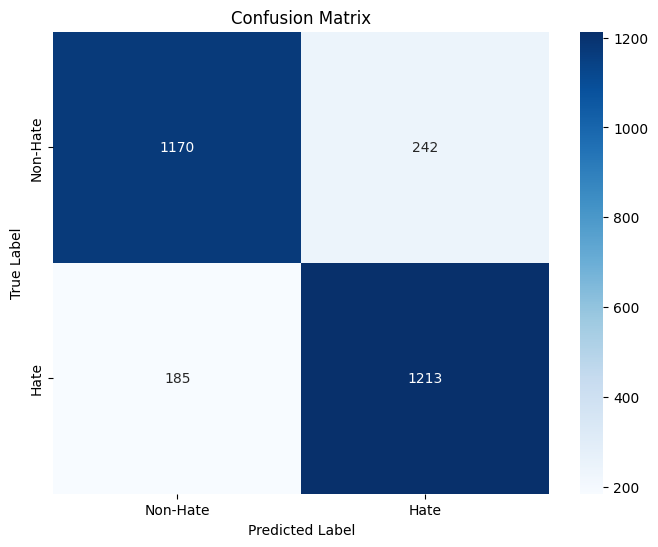

In [823]:
cm = confusion_matrix(y_validation, y_validation_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Hate', 'Hate'],
            yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [824]:
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)


21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [825]:
y_test = df_test['label']

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.8480427046263345
Precision: 0.8336769759450172
Recall: 0.8676680972818311
F1-Score: 0.8503329828250964


22. Create a confusion matrix using the **test dataset**

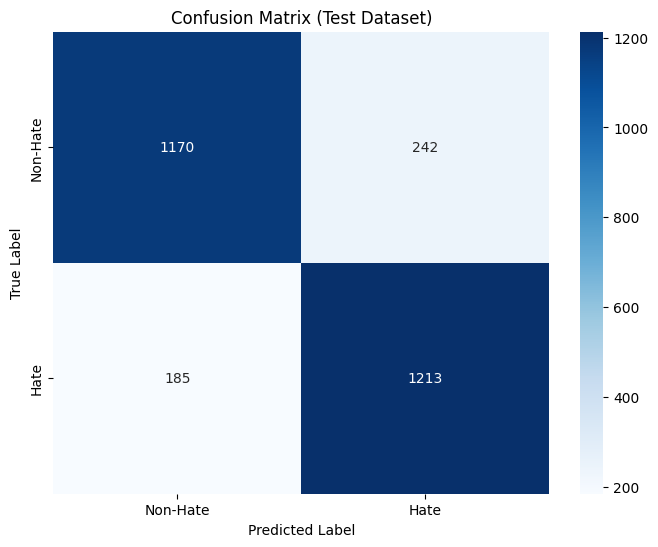

In [826]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Hate', 'Hate'],
            yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Dataset)')
plt.show()


In [827]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define parameter grid for MultinomialNB
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]  # Example values for alpha
}

# Set up GridSearchCV for MultinomialNB
grid = GridSearchCV(MultinomialNB(), param_grid, refit=True, verbose=3)
grid.fit(X_train_transformed, y_train)

# Print best parameters found by GridSearchCV
print("Best Parameters: ", grid.best_params_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .........................alpha=0.1;, score=0.836 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.829 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.839 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.836 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.832 total time=   0.0s
[CV 1/5] END .........................alpha=0.5;, score=0.837 total time=   0.0s
[CV 2/5] END .........................alpha=0.5;, score=0.830 total time=   0.0s
[CV 3/5] END .........................alpha=0.5;, score=0.845 total time=   0.0s
[CV 4/5] END .........................alpha=0.5;, score=0.845 total time=   0.0s
[CV 5/5] END .........................alpha=0.5;, score=0.834 total time=   0.0s
[CV 1/5] END .........................alpha=1.0;, score=0.837 total time=   0.0s
[CV 2/5] END .........................alpha=1.0;,

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [828]:
def try_model(new_input):
    new_input_transformed = vectorizer.transform([new_input])
    prediction = model.predict(new_input_transformed)
    print(f"Prediction for '{new_input}': {prediction[0]}")


In [829]:
try_model("putangina")


Prediction for 'putangina': 1


24. Test the model by providing a hate speech input. The model should predict it as 1

In [830]:
try_model("tangina ni duterte bobo ang puta")

Prediction for 'tangina ni duterte bobo ang puta': 1


In [831]:
try_model("goodmorning love")

Prediction for 'goodmorning love': 0


In [832]:
try_model("galing")

Prediction for 'galing': 1


In [834]:
try_model("magaling tangina")

Prediction for 'magaling tangina': 1
